In [ ]:

# only run this once if required and margin list has changes from website!!! 
# just run everything else below this cell on regular basis

# import margin from westpac website
import tabula
myfile = 'https://www.westpac.com.au/content/dam/public/wbc/documents/pdf/pb/1999030/WOIL_Acceptable_Securities_List.pdf'

df2 = tabula.read_pdf(myfile,pages='all')
frames = [df2[0],df2[1],df2[2],df2[3]]
df2 = pd.concat(frames)
df2.drop(['Unnamed: 0','Unnamed: 1','APIR Code','Fund Name','APIR Code Fund Name'],axis=1) 
split1 = df2[['ASX Code','Security Name','LVR']]
split2 = df2[['ASX Code.1','Security Name.1','LVR.1']]
split2.columns=['ASX Code','Security Name','LVR']
df2 = pd.concat([split1,split2])
df2 = df2.dropna()
df2 = df2.drop_duplicates(subset=['ASX Code'])
df2.to_csv('margin.csv')

In [4]:
import pandas as pd
import datetime
import math
import numpy as np
import pandas_datareader.data as web
from pandas import Series, DataFrame
from sklearn import preprocessing
import matplotlib.pyplot as plt
from datetime import date, timedelta
import yfinance as yf

pd.set_option('mode.chained_assignment',None)    # turn off chain error warning since I use loc function properly

# myfunction to use MACD to give signal

def MAC(MACDiff,MACD,Trigger,PriceMvmt):
    if MACDiff > 0.01:
        if MACD < 0 and MACD < Trigger:
            action = 'Buy - accumulate'
        elif MACD < 0 and MACD > Trigger:
            action = 'Buy - above trigger'
        elif MACD > 0 and MACD > Trigger:
            action = 'Buy - positive signal'
        else:
            action = 'MACD higher but no comment'
    elif MACDiff > -0.01 and MACDiff < 0.01:
        if PriceMvmt > 0:
            action = 'MACD stagnates'
        elif PriceMvmt < 0:
            action = 'MACD stagnates - heavy to sell'
        else:
            action = 'Sideway'
    else:    # MACDIFF IS NEGATIVE
        if MACD > 0:
            action = 'Sell - accumulate (take profit)'      
        elif MACD <0 and PriceMvmt > 0:                 
            action = 'Buy - potential reversal'       #technical bad but ppl still buy? must be good value
        elif MACD <0 and PriceMvmt < 0:                 
            action = 'Sell - positive signal'
        else:
            action = 'MACD lower but no action'
    return action



# my purchase price table
myInput = pd.DataFrame({'Code':['IAG.AX','AGL.AX','WPL.AX','WBC.AX'],
                        'PurchasePrice': [4.955,13.535,20.08,21.35],
                        'Unit': [6060,4447,2538,163],
                        'InPortfolio':['y','y','y','y']
                       })

# pick up data from yahoo finance
start = datetime.datetime(2020, 7, 1)
end = datetime.date.today() + datetime.timedelta(days=1)
#end = datetime.datetime(2020,10,14)


# new code to pick up from csv instead with more details

mystock = pd.read_csv('margin.csv')
mystock = mystock['ASX Code'] + '.AX'
mystock = mystock.replace('^AORD.AX','^AORD')    # all ord does not come with .ax

################# old ways --- remove ####################
#mystock = ['IVC.AX','IAG.AX','LNK.AX','GOLD.AX','A200.AX','NAB.AX','BEAR.AX','BBOZ.AX','WPL.AX','CSL.AX',
#'CQE.AX','ANZ.AX','CBA.AX','AGL.AX','ALL.AX','AMC.AX','ANN.AX','APT.AX','BHP.AX','BKL.AX',
#'CAR.AX','CGF.AX','CIM.AX','TLS.AX','COL.AX','CPU.AX','DMP.AX','FLT.AX','GMG.AX','HVN.AX',
#'JBH.AX','KGN.AX','LLC.AX','MGR.AX','MPL.AX','MQG.AX','ORG.AX','QAN.AX','QBE.AX','^AORD','WBC.AX','WOW.AX']


#['IVC.AX','TLS.AX','IAG.AX','WPL.AX',
 #          'WBC.AX','^AORD','GOLD.AX','BEAR.AX',
  #         'BBOZ.AX','A200.AX','CQE.AX','CSL.AX',
   #        'LNK.AX','NAB.AX','Z1P.AX']
################################################################



#mystock = ['IVC.AX','IAG.AX','AGL.AX']




mycol = ['Code','Close','Movement','Dup','Ddown','Volume','ShortAvg','LongAvg','MACD','Trigger']


mytbl = pd.DataFrame(columns=mycol)

for i in mystock:
    #df = web.DataReader(i, 'yahoo', start, end)[['Close','Volume']]
    
    
    df = yf.download(i, start=start, end=end)[['Close','Volume']]
    
    #test.loc[:,'ShortAvg'] = test.Close.rolling(window=3).mean()
    
    df['Code'] = i
    df.loc[:,'ShortAvg'] = df.Close.rolling(window=10).mean()
    df.loc[:,'LongAvg'] = df.Close.rolling(window=15).mean()
    df['MACD'] = df['ShortAvg'] - df['LongAvg']
    df['Trigger'] = df.MACD.rolling(window=5).mean()
    df['Movement'] = df['Close'].diff()
    #df.loc[df['Movement']<0,'Dup']=0
    #df.loc[df['Movement']>0,'Dup']=df['Movement']/(df['Close']-df['Movement']) * 100    # pctg mvmt
    #df.loc[df['Movement']<0,'Ddown']=-df['Movement']/(df['Close']-df['Movement']) * 100 
    #df.loc[df['Movement']>0,'Ddown']=0
    mytbl = mytbl.append(df)

#mytbl = mytbl[['Code','Close','Movement','Dup','Ddown','Volume','Wkly','TwoWks']]
mytbl = mytbl.reset_index()
mytbl = mytbl.rename(columns={'index':'Date'})


############## SQL TO MERGE WITH MY INPUT ##############
code = pd.merge(mytbl,myInput,on='Code',how='left')
code = code.rename(columns={'index':'Date'})


#remove null values
code['Unit'] = code['Unit'].fillna(0)
code['PurchasePrice'] = code['PurchasePrice'].fillna(0)
code['InPortfolio'] = code['InPortfolio'].fillna('n')

code['Profit'] = (code['Close'] - code['PurchasePrice']) * code['Unit']
#code['AvgPctg'] = (code['Wkly']-code['TwoWks'])/code['TwoWks'] * 100

#code['Diff'] = code['Wkly'] - code['TwoWks']
#code['DdownCnt']=code['Ddown'].rolling(window=14,min_periods=1).count()




# create another table to give signal
#mysignal = code
#mysignal['MACD_Diff'] = mysignal['MACD'].diff(1)
#mysignal['Advice']=mysignal.apply(lambda x:MAC(x['MACD_Diff'],x['MACD'],x['Trigger'],x['Movement']),axis=1)




code['MACD_Diff'] = code['MACD'].diff(1)
code['Advice']=code.apply(lambda x:MAC(x['MACD_Diff'],x['MACD'],x['Trigger'],x['Movement']),axis=1)


code.to_csv('YahooFinance.csv')


#code.head()






#code.to_csv('mysignal.csv')





[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

NameError: name 'mysignal' is not defined

These are the stocks to buy 

Empty DataFrame
Columns: [Code, Close, Movement, Advice]
Index: [] 

 These are my portfolio advise 

Empty DataFrame
Columns: [Code, Close, Movement, Advice]
Index: []

 These are index status 

Empty DataFrame
Columns: [Code, Close, Movement, Advice]
Index: []




[Text(0.5, 1.0, 'GOLD.AX')]

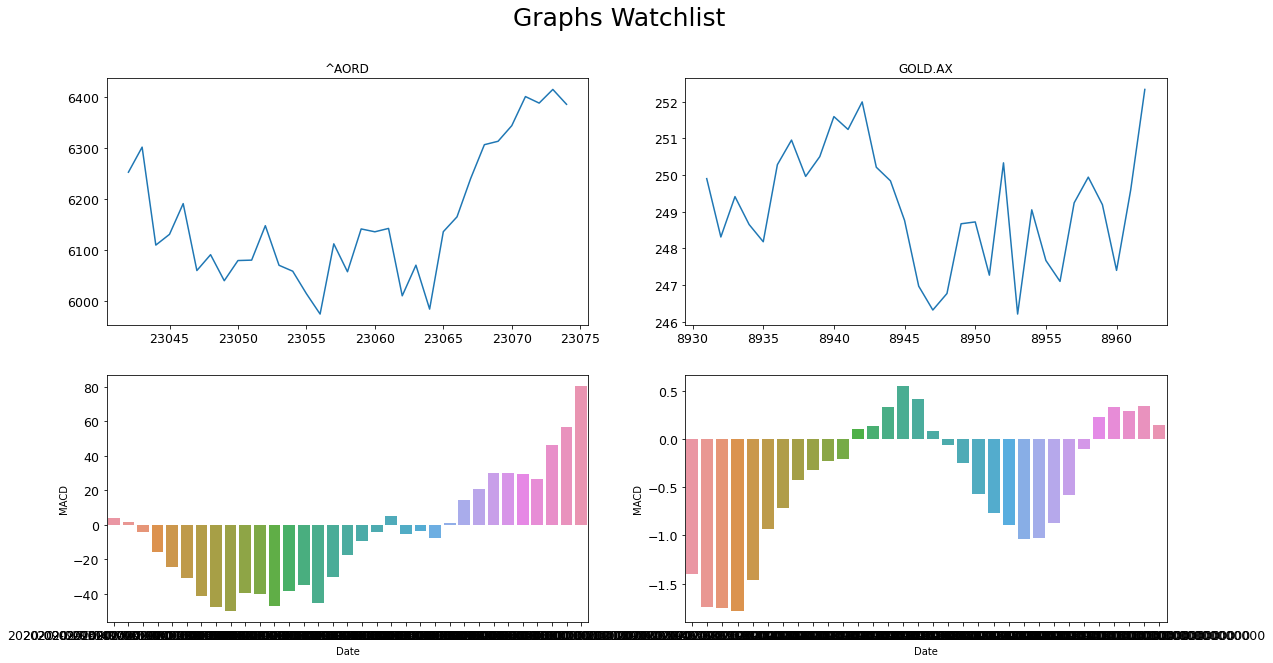

In [154]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

mytime = datetime.date.today() + datetime.timedelta(days=-1)

# show results
a = code[(code['Date']==mytime) & (code['Advice'].str.contains('trigger'))][['Code','Close','Movement','Advice']].sort_values('Advice')

b = code[(code['Date']==mytime) & (code['Code'].isin(['IVC.AX','WPL.AX','AGL.AX','WBC.AX']))][['Code','Close','Movement','Advice']].sort_values('Advice')

c = code[(code['Date']==mytime) & (code['Code'].isin(['^AORD','GOLD.AX']))][['Code','Close','Movement','Advice']].sort_values('Advice')


print ('These are the stocks to buy \n\n{} \n\n These are my portfolio advise \n\n{}\n\n These are index status \n\n{}\n\n'.format(a,b,c))



mycode = ['^AORD','GOLD.AX'] # add or change codes here

data = code[(code['Code'].isin(mycode)) &  (code['Date']>'2020-9-1') ]
fig, ax = plt.subplots(2,len(mycode),figsize=(19,10))

fig.suptitle('Graphs Watchlist', fontsize=25)

fontsize = 12.5
for t in ax.flatten():
    labels = t.get_xticklabels() + t.get_yticklabels()
    [label.set_size(fontsize) for label in labels]                # set_fontname(fontname) to change font and set fontname = 'Times New Roman'


sns.barplot(x="Date", y="MACD", data=data[data['Code']==mycode[0]], ax=ax[1,0])
sns.barplot(x="Date", y="MACD", data=data[data['Code']==mycode[1]], ax=ax[1,1])
#sns.barplot(x="Date", y="MACD", data=data[data['Code']==mycode[2]], ax=ax[1,2])
#sns.barplot(x="Date", y="MACD", data=data[data['Code']==mycode[3]], ax=ax[1,3])


chart1 = sns.lineplot(data=data[data['Code']==mycode[0]]['Close'],ax=ax[0,0])
chart2 = sns.lineplot(data=data[data['Code']==mycode[1]]['Close'],ax=ax[0,1])
#chart3 = sns.lineplot(data=data[data['Code']==mycode[2]]['Close'],ax=ax[0,2])
#chart4 = sns.lineplot(data=data[data['Code']==mycode[3]]['Close'],ax=ax[0,3])


chart1.set(title=mycode[0])
chart2.set(title=mycode[1])
#chart3.set(title=mycode[2])
#chart4.set(title=mycode[3])


In [168]:
datetime(2020,10,15)

TypeError: 'module' object is not callable

In [106]:
#x = code[(code['Code']=='WPL.AX') & (code['Date']<'2020-10-12')].tail(60)
pd.options.display.float_format = '{:,.2f}'.format
code['voldiff']=code['Volume'].diff(1)
code['max']=code['Close'].max()
code['Pctg']=(code['max']-code['Close'])/x['Close']
code['voldiff']=code['voldiff'].astype('float64')
code.drop(['Unit','Dup','Ddown','PurchasePrice','Profit'],axis=1)

,Date,Code,Close,Movement,Volume,ShortAvg,LongAvg,MACD,Trigger,InPortfolio,MACD_Diff,Advice,voldiff,max,Pctg
0,2020-07-01,WPL.AX,21.60,nan,2177395,nan,nan,nan,nan,y,nan,MACD lower but no action,nan,"6,414.20",nan
1,2020-07-02,WPL.AX,21.77,0.17,1954751,nan,nan,nan,nan,y,nan,MACD lower but no action,"-222,644.00","6,414.20",nan
2,2020-07-03,WPL.AX,21.65,-0.12,1823163,nan,nan,nan,nan,y,nan,MACD lower but no action,"-131,588.00","6,414.20",nan
3,2020-07-06,WPL.AX,21.58,-0.07,1557653,nan,nan,nan,nan,y,nan,MACD lower but no action,"-265,510.00","6,414.20",nan
4,2020-07-07,WPL.AX,21.27,-0.31,2661952,nan,nan,nan,nan,y,nan,MACD lower but no action,"1,104,299.00","6,414.20",nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23218,2020-10-12,BEAR.AX,11.48,-0.01,41537,11.81,11.88,-0.07,-0.05,n,0.00,MACD stagnates - heavy to sell,"5,349.00","6,414.20",nan
23219,2020-10-13,BEAR.AX,11.36,-0.12,63196,11.76,11.83,-0.07,-0.06,n,-0.00,MACD stagnates - heavy to sell,"21,659.00","6,414.20",nan
23220,2020-10-14,BEAR.AX,11.37,0.01,34225,11.68,11.78,-0.09,-0.07,n,-0.02,Buy - potential reversal,"-28,971.00","6,414.20",nan
23221,2020-10-15,BEAR.AX,11.31,-0.06,15004,11.61,11.74,-0.12,-0.09,n,-0.03,Sell - positive signal,"-19,221.00","6,414.20",nan


In [110]:
import pandas as pd
import datetime
import math
import numpy as np
import pandas_datareader.data as web
from pandas import Series, DataFrame
from sklearn import preprocessing
import matplotlib.pyplot as plt
from datetime import date, timedelta
import yfinance as yf

pd.set_option('mode.chained_assignment',None)    # turn off chain error warning since I use loc function properly

# myfunction to use MACD to give signal

def MAC(MACDiff,MACD,Trigger,PriceMvmt):
    if MACDiff > 0.01:
        if MACD < 0 and MACD < Trigger:
            action = 'Buy - accumulate'
        elif MACD < 0 and MACD > Trigger:
            action = 'Buy - above trigger'
        elif MACD > 0 and MACD > Trigger:
            action = 'Buy - positive signal'
        else:
            action = 'MACD higher but no comment'
    elif MACDiff > -0.01 and MACDiff < 0.01:
        if PriceMvmt > 0:
            action = 'MACD stagnates'
        elif PriceMvmt < 0:
            action = 'MACD stagnates - heavy to sell'
        else:
            action = 'Sideway'
    else:    # MACDIFF IS NEGATIVE
        if MACD > 0:
            action = 'Sell - accumulate (take profit)'      
        elif MACD <0 and PriceMvmt > 0:                 
            action = 'Buy - potential reversal'       #technical bad but ppl still buy? must be good value
        elif MACD <0 and PriceMvmt < 0:                 
            action = 'Sell - positive signal'
        else:
            action = 'MACD lower but no action'
    return action



# my purchase price table
myInput = pd.DataFrame({'Code':['IAG.AX','AGL.AX','WPL.AX','WBC.AX'],
                        'PurchasePrice': [4.955,13.535,20.08,21.35],
                        'Unit': [6060,4447,2538,163],
                        'InPortfolio':['y','y','y','y']
                       })

# pick up data from yahoo finance
start = datetime.datetime(2020, 7, 1)
end = datetime.date.today() + datetime.timedelta(days=1)
#end = datetime.datetime(2020,10,14)


# new code to pick up from csv instead with more details

mystock = pd.read_csv('margin.csv')
mystock = mystock['ASX Code'] + '.AX'
mystock = mystock.replace('^AORD.AX','^AORD')    # all ord does not come with .ax

################# old ways --- remove ####################
#mystock = ['IVC.AX','IAG.AX','LNK.AX','GOLD.AX','A200.AX','NAB.AX','BEAR.AX','BBOZ.AX','WPL.AX','CSL.AX',
#'CQE.AX','ANZ.AX','CBA.AX','AGL.AX','ALL.AX','AMC.AX','ANN.AX','APT.AX','BHP.AX','BKL.AX',
#'CAR.AX','CGF.AX','CIM.AX','TLS.AX','COL.AX','CPU.AX','DMP.AX','FLT.AX','GMG.AX','HVN.AX',
#'JBH.AX','KGN.AX','LLC.AX','MGR.AX','MPL.AX','MQG.AX','ORG.AX','QAN.AX','QBE.AX','^AORD','WBC.AX','WOW.AX']


#['IVC.AX','TLS.AX','IAG.AX','WPL.AX',
 #          'WBC.AX','^AORD','GOLD.AX','BEAR.AX',
  #         'BBOZ.AX','A200.AX','CQE.AX','CSL.AX',
   #        'LNK.AX','NAB.AX','Z1P.AX']
################################################################



#mystock = ['IVC.AX','IAG.AX','AGL.AX']




mycol = ['Code','Close','Movement','Dup','Ddown','Volume','ShortAvg','LongAvg','MACD','Trigger','Mov_Vol','Max']


mytbl = pd.DataFrame(columns=mycol)

for i in mystock:
    #df = web.DataReader(i, 'yahoo', start, end)[['Close','Volume']]
    
    
    df = yf.download(i, start=start, end=end)[['Close','Volume']]
    
    #test.loc[:,'ShortAvg'] = test.Close.rolling(window=3).mean()
    
    df['Code'] = i
    df.loc[:,'ShortAvg'] = df.Close.rolling(window=10).mean()
    df.loc[:,'LongAvg'] = df.Close.rolling(window=15).mean()
    df['MACD'] = df['ShortAvg'] - df['LongAvg']
    df['Trigger'] = df.MACD.rolling(window=5).mean()
    df['Movement'] = df['Close'].diff()
    df['Mov_Vol'] = df['Volume'].diff()
    df['Max'] = df['Close'].max()
    #df.loc[df['Movement']<0,'Dup']=0
    #df.loc[df['Movement']>0,'Dup']=df['Movement']/(df['Close']-df['Movement']) * 100    # pctg mvmt
    #df.loc[df['Movement']<0,'Ddown']=-df['Movement']/(df['Close']-df['Movement']) * 100 
    #df.loc[df['Movement']>0,'Ddown']=0
    mytbl = mytbl.append(df)

#mytbl = mytbl[['Code','Close','Movement','Dup','Ddown','Volume','Wkly','TwoWks']]
mytbl = mytbl.reset_index()
mytbl = mytbl.rename(columns={'index':'Date'})

code = pd.merge(mytbl,myInput,on='Code',how='left')
code = code.rename(columns={'index':'Date'})

#remove null values
code['Unit'] = code['Unit'].fillna(0)
code['PurchasePrice'] = code['PurchasePrice'].fillna(0)
code['InPortfolio'] = code['InPortfolio'].fillna('n')

code['Profit'] = (code['Close'] - code['PurchasePrice']) * code['Unit']
#code['AvgPctg'] = (code['Wkly']-code['TwoWks'])/code['TwoWks'] * 100

#code['Diff'] = code['Wkly'] - code['TwoWks']
#code['DdownCnt']=code['Ddown'].rolling(window=14,min_periods=1).count()




# create another table to give signal
#mysignal = code
#mysignal['MACD_Diff'] = mysignal['MACD'].diff(1)
#mysignal['Advice']=mysignal.apply(lambda x:MAC(x['MACD_Diff'],x['MACD'],x['Trigger'],x['Movement']),axis=1)




code['MACD_Diff'] = code['MACD'].diff(1)
code['Advice']=code.apply(lambda x:MAC(x['MACD_Diff'],x['MACD'],x['Trigger'],x['Movement']),axis=1)


code.to_csv('YahooFinance.csv')


#code.head()






#code.to_csv('mysignal.csv')


# show results
a = mysignal[(mysignal['Date']=='2020-10-16') & (mysignal['Advice'].str.contains('Buy'))][['Code','Close','Movement','Advice']].sort_values('Advice')

b = mysignal[(mysignal['Date']=='2020-10-16') & (mysignal['Advice'].str.contains('Sell'))][['Code','Close','Movement','Advice']].sort_values('Advice')

print ('These are the stocks to buy \n\n{} \n\n These are stocks to sell \n\n {}'.format(a,b))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

NameError: name 'mysignal' is not defined

In [116]:
code.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23223 entries, 0 to 23222
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           23223 non-null  datetime64[ns]
 1   Code           23223 non-null  object        
 2   Close          23223 non-null  float64       
 3   Movement       22924 non-null  float64       
 4   Dup            0 non-null      object        
 5   Ddown          0 non-null      object        
 6   Volume         23223 non-null  object        
 7   ShortAvg       20540 non-null  float64       
 8   LongAvg        19050 non-null  float64       
 9   MACD           19050 non-null  float64       
 10  Trigger        17858 non-null  float64       
 11  Mov_Vol        22924 non-null  float64       
 12  Max            23223 non-null  float64       
 13  PurchasePrice  23223 non-null  float64       
 14  Unit           23223 non-null  float64       
 15  InPortfolio    2322

In [115]:
code['Pctg']=(code['Max']-code['Close'])/x['Close']
code.drop(['Unit','Dup','Ddown','PurchasePrice','Profit'],axis=1)

code[(code['Advice']=='Buy - positive signal') & (code['Date']=='2020-10-16')]

,Date,Code,Close,Movement,Dup,Ddown,Volume,ShortAvg,LongAvg,MACD,Trigger,Mov_Vol,Max,PurchasePrice,Unit,InPortfolio,Profit,MACD_Diff,Advice,Pctg
77,2020-10-16,WPL.AX,18.42,-0.13,NaN,NaN,4206886,18.27,18.10,0.17,-0.01,"1,056,886.00",21.77,20.08,"2,538.00",y,"-4,213.08",0.16,Buy - positive signal,nan
151,2020-10-16,A200.AX,103.50,-0.63,NaN,NaN,32462,102.30,101.19,1.12,0.61,"20,401.00",104.13,0.00,0.00,n,0.00,0.35,Buy - positive signal,nan
229,2020-10-16,AFI.AX,6.79,0.15,NaN,NaN,336072,6.48,6.42,0.06,0.04,"-41,125.00",6.79,0.00,0.00,n,0.00,0.02,Buy - positive signal,nan
385,2020-10-16,AMC.AX,16.14,0.11,NaN,NaN,3491834,15.75,15.60,0.14,0.12,"1,393,359.00",16.14,0.00,0.00,n,0.00,0.02,Buy - positive signal,nan
463,2020-10-16,ANN.AX,40.35,0.49,NaN,NaN,662682,38.96,38.39,0.57,0.38,"410,644.00",40.58,0.00,0.00,n,0.00,0.11,Buy - positive signal,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21826,2020-10-16,PME.AX,30.02,-1.21,NaN,NaN,396417,28.14,27.70,0.44,0.23,"-407,817.00",31.23,0.00,0.00,n,0.00,0.13,Buy - positive signal,nan
22060,2020-10-16,PWH.AX,4.92,-0.11,NaN,NaN,36489,4.73,4.71,0.02,0.00,"-108,045.00",5.15,0.00,0.00,n,0.00,0.02,Buy - positive signal,nan
22840,2020-10-16,WSA.AX,2.26,0.00,NaN,NaN,1758975,2.22,2.17,0.04,0.01,"-652,169.00",2.73,0.00,0.00,n,0.00,0.02,Buy - positive signal,nan
22996,2020-10-16,NWH.AX,2.08,-0.05,NaN,NaN,1707702,2.11,2.08,0.03,0.01,"28,440.00",2.26,0.00,0.00,n,0.00,0.02,Buy - positive signal,nan


In [122]:
test = code[(code['Code']=='IVC.AX') & (code['Date']>'2020-09-25')]
test = test.drop(['Unit','Dup','Ddown','PurchasePrice','Profit'],axis=1)
test['k'] = test['Close']/test['Max']

test

,Date,Code,Close,Movement,Volume,ShortAvg,LongAvg,MACD,Trigger,Mov_Vol,Max,InPortfolio,MACD_Diff,Advice,Pctg,k
5285,2020-09-28,IVC.AX,9.80,-0.14,319378,9.66,9.66,-0.00,-0.03,"-99,832.00",10.86,n,0.01,MACD stagnates - heavy to sell,nan,0.90
5286,2020-09-29,IVC.AX,9.88,0.08,229674,9.69,9.66,0.03,-0.01,"-89,704.00",10.86,n,0.03,Buy - positive signal,nan,0.91
5287,2020-09-30,IVC.AX,9.77,-0.11,806851,9.72,9.67,0.05,0.01,"577,177.00",10.86,n,0.02,Buy - positive signal,nan,0.90
5288,2020-10-01,IVC.AX,9.85,0.08,417089,9.75,9.69,0.06,0.03,"-389,762.00",10.86,n,0.01,Buy - positive signal,nan,0.91
5289,2020-10-02,IVC.AX,9.84,-0.01,339995,9.78,9.70,0.07,0.04,"-77,094.00",10.86,n,0.01,Buy - positive signal,nan,0.91
5290,2020-10-05,IVC.AX,10.15,0.31,255923,9.83,9.74,0.09,0.06,"-84,072.00",10.86,n,0.02,Buy - positive signal,nan,0.93
5291,2020-10-06,IVC.AX,10.24,0.09,350013,9.91,9.79,0.12,0.08,"94,090.00",10.86,n,0.03,Buy - positive signal,nan,0.94
5292,2020-10-07,IVC.AX,10.42,0.18,363345,9.97,9.84,0.13,0.10,"13,332.00",10.86,n,0.00,MACD stagnates,nan,0.96
5293,2020-10-08,IVC.AX,10.38,-0.04,331506,10.03,9.90,0.13,0.11,"-31,839.00",10.86,n,0.00,MACD stagnates - heavy to sell,nan,0.96
5294,2020-10-09,IVC.AX,10.17,-0.21,660742,10.05,9.94,0.11,0.12,"329,236.00",10.86,n,-0.02,Sell - accumulate (take profit),nan,0.94


In [81]:
for i,k in enumerate(np):
        if i>0:
            print (np[:2])
    

[5, 9]
[5, 9]
[5, 9]
[5, 9]


In [86]:
for i in np:
    print (np[i:i+2])

[]
[]
[4, 2]
[2]
[3, 4]


In [85]:
np[1:2]

[9]

These are the stocks to buy 

         Code  Close  Movement               Advice
307    AGL.AX  13.45     -0.23  Buy - above trigger
697    AZJ.AX   4.13      0.02  Buy - above trigger
3427   NCM.AX  31.55      0.09  Buy - above trigger
4051   TCL.AX  13.70     -0.38  Buy - above trigger
12004  HUO.AX   2.71      0.01  Buy - above trigger
14887  IPH.AX   7.33     -0.02  Buy - above trigger
15199  OGC.AX   2.21      0.03  Buy - above trigger
15277  PFP.AX   2.92      0.02  Buy - above trigger
20812  JIN.AX  12.05     -0.27  Buy - above trigger 

 These are my portfolio advise 

        Code  Close  Movement                 Advice
307   AGL.AX  13.45     -0.23    Buy - above trigger
77    WPL.AX  18.42     -0.13  Buy - positive signal
2179  WBC.AX  18.66     -0.12  Buy - positive signal
5299  IVC.AX  10.41      0.11  Buy - positive signal

 These are index status 

          Code    Close  Movement                           Advice
23074    ^AORD 6,385.00    -29.20            Buy - posit

[Text(0.5, 1.0, 'IVC.AX')]

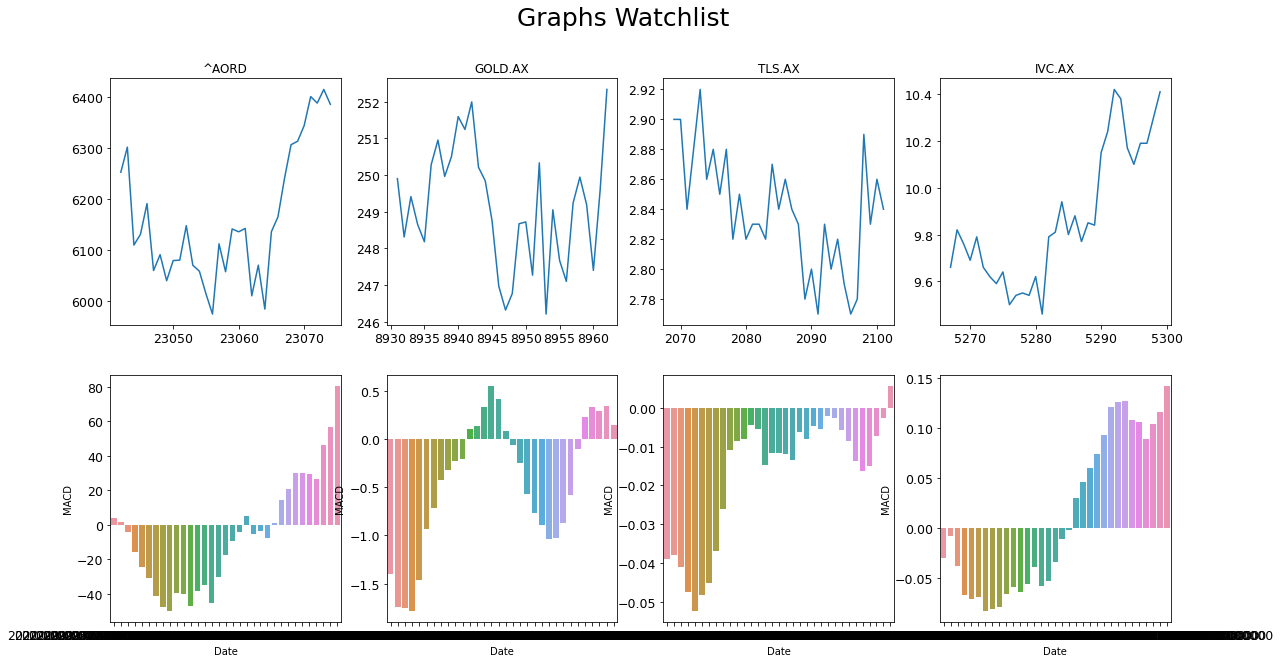

In [149]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# show results
a = code[(code['Date']=='2020-10-16') & (code['Advice'].str.contains('trigger'))][['Code','Close','Movement','Advice']].sort_values('Advice')

b = code[(code['Date']=='2020-10-16') & (code['Code'].isin(['IVC.AX','WPL.AX','AGL.AX','WBC.AX']))][['Code','Close','Movement','Advice']].sort_values('Advice')

c = code[(code['Date']=='2020-10-16') & (code['Code'].isin(['^AORD','GOLD.AX']))][['Code','Close','Movement','Advice']].sort_values('Advice')


print ('These are the stocks to buy \n\n{} \n\n These are my portfolio advise \n\n{}\n\n These are index status \n\n{}\n\n'.format(a,b,c))



mycode = ['^AORD','GOLD.AX','TLS.AX','IVC.AX'] # add or change codes here

data = code[(code['Code'].isin(mycode)) &  (code['Date']>'2020-9-1') ]
fig, ax = plt.subplots(2,len(mycode),figsize=(19,10))

fig.suptitle('Graphs Watchlist', fontsize=25)

fontsize = 12.5
for t in ax.flatten():
    labels = t.get_xticklabels() + t.get_yticklabels()
    [label.set_size(fontsize) for label in labels]                # set_fontname(fontname) to change font and set fontname = 'Times New Roman'


sns.barplot(x="Date", y="MACD", data=data[data['Code']==mycode[0]], ax=ax[1,0])
sns.barplot(x="Date", y="MACD", data=data[data['Code']==mycode[1]], ax=ax[1,1])
sns.barplot(x="Date", y="MACD", data=data[data['Code']==mycode[2]], ax=ax[1,2])
sns.barplot(x="Date", y="MACD", data=data[data['Code']==mycode[3]], ax=ax[1,3])


chart1 = sns.lineplot(data=data[data['Code']==mycode[0]]['Close'],ax=ax[0,0])
chart2 = sns.lineplot(data=data[data['Code']==mycode[1]]['Close'],ax=ax[0,1])
chart3 = sns.lineplot(data=data[data['Code']==mycode[2]]['Close'],ax=ax[0,2])
chart4 = sns.lineplot(data=data[data['Code']==mycode[3]]['Close'],ax=ax[0,3])


chart1.set(title=mycode[0])
chart2.set(title=mycode[1])
chart3.set(title=mycode[2])
chart4.set(title=mycode[3])


[Text(0.5, 1.0, 'WBC.AX')]

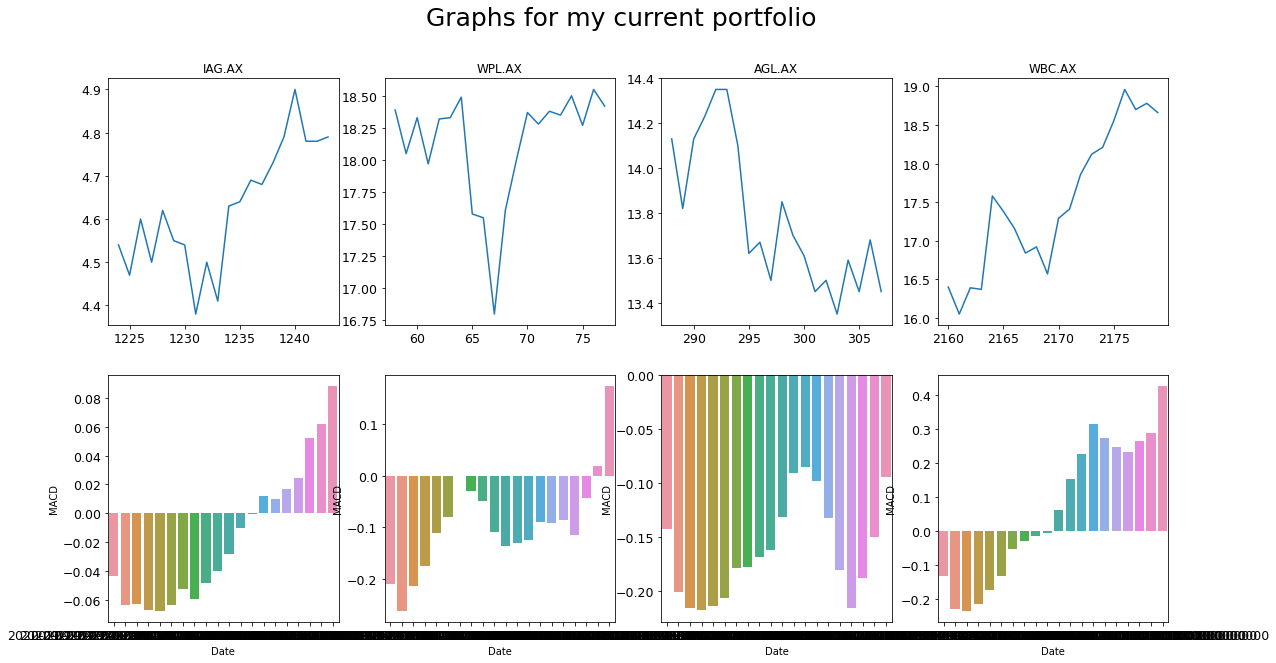

In [132]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

mycode = ['IAG.AX','WPL.AX','AGL.AX','WBC.AX'] # add or change codes here

data = code[(code['Code'].isin(mycode)) &  (code['Date']>'2020-9-19') ]
fig, ax = plt.subplots(2,len(mycode),figsize=(19,10))

fig.suptitle('Graphs for my current portfolio', fontsize=25)

fontsize = 12.5
for t in ax.flatten():
    labels = t.get_xticklabels() + t.get_yticklabels()
    [label.set_size(fontsize) for label in labels]                # set_fontname(fontname) to change font and set fontname = 'Times New Roman'


sns.barplot(x="Date", y="MACD", data=data[data['Code']==mycode[0]], ax=ax[1,0])
sns.barplot(x="Date", y="MACD", data=data[data['Code']==mycode[1]], ax=ax[1,1])
sns.barplot(x="Date", y="MACD", data=data[data['Code']==mycode[2]], ax=ax[1,2])
sns.barplot(x="Date", y="MACD", data=data[data['Code']==mycode[3]], ax=ax[1,3])


chart1 = sns.lineplot(data=data[data['Code']==mycode[0]]['Close'],ax=ax[0,0])
chart2 = sns.lineplot(data=data[data['Code']==mycode[1]]['Close'],ax=ax[0,1])
chart3 = sns.lineplot(data=data[data['Code']==mycode[2]]['Close'],ax=ax[0,2])
chart4 = sns.lineplot(data=data[data['Code']==mycode[3]]['Close'],ax=ax[0,3])


chart1.set(title=mycode[0])
chart2.set(title=mycode[1])
chart3.set(title=mycode[2])
chart4.set(title=mycode[3])


